In [22]:
# Core imports yay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from sklearn.multiclass import OneVsOneClassifier
# Preprocessing and visualization
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Metric functions
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import accuracy_score

# Models
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.dummy        import DummyClassifier
from sklearn.tree         import DecisionTreeClassifier
from sklearn.svm          import SVC
# Model selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Ignore warnings if they happen, we don't care (that much)
import warnings; warnings.simplefilter('ignore')

# Cross-validation takes a minute, so we will save these models
from sklearn.externals import joblib
from sklearn.base import clone


from lyric_features import genre_transform_lyrics

In [2]:
df     = pd.read_csv("data/lyrical_genius.csv")

# Remove pop songs, they are all over the place and hurt classification
df = df[(df["Genre"] != "pop")]

# Remove some irrelevant columns
df = df.drop(columns="Unnamed: 0")
df = df.drop(columns="Unnamed: 0.1")

# We go ahead and remove ALL duplicates
df = df.drop_duplicates(subset=["Name","Artist"],keep=False)

# Give each genre a new cool color
genres = df["Genre"].unique()
unique_colors = [
    '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080'
]
colors = {}
i = 0
for genre in genres:
    colors[genre] = unique_colors[i]
    i+=1

counts    = df["Genre"].value_counts()
colors_list = [colors[genre] for genre in genres]

df, vectorizer = genre_transform_lyrics(df,20)

['come', 'day', 'don', 'good', 'got', 'just', 'know', 'let', 'life', 'like', 'little', 'll', 'love', 'make', 'man', 'said', 'say', 'scp', 'time', 'way', 'TTR', 'Avg_Wrdlen']


In [3]:
# Split data into data frames of the right type
x_cols    = ["Is_Exp","Danceability","Energy","Key","Loudness","Mode","Speechiness","Acousticness","Instrumentalness","Liveness","Valence","Tempo","Time_Signature"]
y_cols    = ["Genre"]
meta_cols = ["Id","Popularity","Name","Artist"]
lyr_cols  = vectorizer.get_feature_names() + ["TTR","Avg_Wrdlen"]

X,y,meta = df[x_cols],df[y_cols].iloc[:,0],df[meta_cols]

# Split 
X_trainP, X_testP, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=1234, stratify=y)

extras    = pd.DataFrame()
counts    = y_train.value_counts()
min_count = min(counts)
extra_y   = pd.Series()
for genre in genres:
    for i in range(min_count):
        extra_y = extra_y.append(pd.Series([genre]))
    extras = extras.append(X_trainP[y_train==genre].sample(n=min_count,replace=False))
X_trainP = extras
y_train = extra_y

In [4]:
# Scale the data and fit run 2D PCA on it
scaler   = StandardScaler()
scaler.fit(X_trainP)
X_train = scaler.transform(X_trainP)
X_test  = scaler.transform(X_testP)

In [5]:
X_train.shape

(1566, 13)

In [6]:
clf = LogisticRegressionCV(cv=5, random_state=1234, multi_class="multinomial")
clf.fit(X_train,y_train)

print(clf)

joblib.dump(clf, "logistic.pkl")
y_pred = clf.predict(X_test)
training = clf.score(X_train, y_train)
testing  = clf.score(X_test,  y_test)
print("Training Accuracy: {}".format(training))
print("Testing  Accuracy: {}".format(testing))
print(genres)
print(confusion_matrix(y_test,y_pred,labels=genres))
print(classification_report(y_test, y_pred)) 

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='multinomial', n_jobs=None, penalty='l2',
           random_state=1234, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)
Training Accuracy: 0.7222222222222222
Testing  Accuracy: 0.79185119574845
['rnb' 'hiphop' 'country' 'classical' 'edm_dance' 'rock']
[[ 33  16   9   0   4   3]
 [ 22  55   2   0   2   0]
 [ 21   0 121   3   2  33]
 [  1   1  18 526  10   3]
 [ 12   5  17   1 109  25]
 [  3   1  12   0   9  50]]
              precision    recall  f1-score   support

   classical       0.99      0.94      0.97       559
     country       0.68      0.67      0.67       180
   edm_dance       0.80      0.64      0.71       169
      hiphop       0.71      0.68      0.69        81
         rnb       0.36      0.51      0.42        65
        rock       0.44      0.67      0.53        75

   micro avg       0.

In [7]:
missed = X_test[(y_test != y_pred)]
ymiss  = y_test[(y_test != y_pred)]
missP  = clf.predict_proba(missed)

In [8]:
maxclass = missP.argmax(axis=1)
maxprob  = missP.max(axis=1)
biggest  = maxprob.argmax()

In [9]:
print(ymiss.iloc[biggest]) # Actual
print(max(max(clf.predict_proba(missed[biggest].reshape(1,-1)))))
print(clf.predict(missed[biggest].reshape(1,-1)))

rnb
0.9804370324830941
['hiphop']


In [10]:
scaler.inverse_transform(missed[biggest])

array([ 1.0000e+00,  8.9800e-01,  6.7700e-01,  1.0000e+00, -6.9070e+00,
        1.0000e+00,  3.6200e-01,  3.5400e-01,  4.8500e-06,  4.4900e-01,
        8.6400e-01,  1.5502e+02,  4.0000e+00])

In [11]:
for i in range(len(clf.classes_)):
    print(clf.classes_[i])
    todos      = [(clf.coef_[i][j],list(X)[j]) for j in range(len(list(X)))]
    todos.sort(key=lambda x: abs(x[0]))
    for i in range(len(todos)):
        print(todos[i])

classical
(-0.1292597792276011, 'Mode')
(0.1569180924906271, 'Liveness')
(-0.1632586643070189, 'Tempo')
(-0.228282223895718, 'Key')
(-0.2591444374023151, 'Time_Signature')
(0.35511967218871265, 'Speechiness')
(0.3671887697575097, 'Energy')
(0.43326013077154846, 'Valence')
(0.5070590057541889, 'Is_Exp')
(0.9804583302656056, 'Acousticness')
(-1.3344857139520536, 'Danceability')
(1.6207446105587562, 'Instrumentalness')
(-2.7554639387709945, 'Loudness')
country
(0.007519767186701086, 'Time_Signature')
(0.06614022691364303, 'Key')
(0.07575409584085906, 'Tempo')
(-0.08954636997179964, 'Liveness')
(0.37974288917056204, 'Loudness')
(0.41711207885547225, 'Acousticness')
(-0.5286389808886242, 'Energy')
(0.6192413193270783, 'Mode')
(-0.7845020455388401, 'Danceability')
(0.8960628543366024, 'Valence')
(-1.0784620319160465, 'Instrumentalness')
(-1.636603820182925, 'Speechiness')
(-2.207858705649459, 'Is_Exp')
edm_dance
(0.0032269814895507275, 'Liveness')
(-0.029499723700539143, 'Acousticness')
(0.0

In [12]:
def best_classifier(X, y, t_clf, params,scores=["accuracy"]) :
    """
    Sweeps different settings for the hyperparameters of a Decision Tree classifier,
    calculating the k-fold CV performance for each setting and metric,
    then selects the hyperparameters that maximize the average performance for each metric.
    """
    best_parms = []
    
    for score in scores:
        base_clf = clone(t_clf)
        print("Scoring for {}".format(score))
        clf   = GridSearchCV(base_clf, params, cv=5,scoring=score)
        
        clf.fit(X,y)
        print("Done fitting")
        
        mts   = clf.cv_results_["mean_test_score"]
        parms = clf.cv_results_["params"]
        
        for mt, parm in zip(mts,parms):
            print("Score: {:.4f}; Parameters {}".format(mt, parm))
        
        best_parms.append(clf.best_estimator_)
    return best_parms[0]

In [26]:
weights = ["uniform"]
params  = {
    "n_neighbors": range(5,22,2)
}
knn = KNeighborsClassifier()
clf = best_classifier(X_train,y_train,knn,params,scores=["precision"])

print(clf)
# clf = KNeighborsClassifier(n_neighbors=1)
# clf.fit(X_train, y_train)

joblib.dump(clf, "knn.pkl")

y_pred = clf.predict(X_test)
training = clf.score(X_train, y_train)
testing  = clf.score(X_test,  y_test)
print("Training Accuracy: {}".format(training))
print("Testing  Accuracy: {}".format(testing))
print(confusion_matrix(y_test,y_pred,labels=genres))
print(classification_report(y_test, y_pred)) 

Scoring for precision


ValueError: Target is multiclass but average='binary'. Please choose another average setting.

In [14]:
params = {
    "max_depth": range(5,12),
    "min_samples_leaf": range(1,10),
    "criterion": ["entropy","gini"]
}
t = DecisionTreeClassifier()

# DTree = best_classifier(X_train, y_train, t, params, scores=["accuracy"])[0]


DTree = DecisionTreeClassifier(max_depth=9, min_samples_leaf=4, criterion="gini")
DTree.fit(X_train, y_train)
print(DTree)
joblib.dump(DTree, "dtree.pkl")

# predict genres of test data
accuracy = DTree.score(X_test,y_test)
y_pred = DTree.predict(X_test)
training = DTree.score(X_train, y_train)
testing  = DTree.score(X_test,  y_test)
print("Training Accuracy: {}".format(training))
print("Testing  Accuracy: {}".format(testing))
print(confusion_matrix(y_test,y_pred,labels=genres))
print(classification_report(y_test, y_pred))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Training Accuracy: 0.8301404853128991
Testing  Accuracy: 0.7723649247121346
[[ 41  12   7   0   1   4]
 [ 20  52   3   0   3   3]
 [ 32   2 115   4   9  18]
 [  9   1  16 520  11   2]
 [ 22   3  20   1 103  20]
 [ 13   1  12   0   8  41]]
              precision    recall  f1-score   support

   classical       0.99      0.93      0.96       559
     country       0.66      0.64      0.65       180
   edm_dance       0.76      0.61      0.68       169
      hiphop       0.73      0.64      0.68        81
         rnb       0.30      0.63      0.41        65
        rock       0.47      0.55      0.50        75

   micro avg       0.77      0.77 

In [15]:
importance = DTree.feature_importances_
d_feats      = list(X)
todos      = [(importance[i],d_feats[i]) for i in range(len(d_feats))]
todos.sort(key=lambda x: x[0],reverse=True)

In [16]:
todos

[(0.24007244091331523, 'Loudness'),
 (0.12070987254439697, 'Speechiness'),
 (0.11802700079494063, 'Is_Exp'),
 (0.11786475507745937, 'Instrumentalness'),
 (0.10408651487809598, 'Acousticness'),
 (0.10218358944653987, 'Danceability'),
 (0.05606085475103492, 'Energy'),
 (0.04289684854243885, 'Valence'),
 (0.042797817418351876, 'Tempo'),
 (0.023937645622222975, 'Liveness'),
 (0.018854671429500952, 'Mode'),
 (0.012507988581702458, 'Key'),
 (0.0, 'Time_Signature')]

In [17]:
total = 0
for x in todos:
    total += x[0]
total

1.0

In [18]:
len(todos)

13

In [19]:
# compare to stratified dummy classifier
dummy = DummyClassifier(strategy='stratified')


dummy.fit(X_train,y_train)

joblib.dump(dummy, "dummy.pkl")
dummy_accuracy = dummy.score(X_test,y_test)
print( "Dummy classifier accuracy is" )
print(dummy_accuracy)

Dummy classifier accuracy is
0.16031886625332153


In [29]:
def graph_features(coef, names, filename="", top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()

Scoring for accuracy
Done fitting
Score: 0.6335; Parameters {'C': 0.001}
Score: 0.6705; Parameters {'C': 0.01}
Score: 0.7075; Parameters {'C': 0.1}
Score: 0.7101; Parameters {'C': 1.0}
Score: 0.7069; Parameters {'C': 10.0}
Score: 0.7050; Parameters {'C': 100.0}
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Training Accuracy: 0.7298850574712644
Testing  Accuracy: 0.804251550044287
[[ 34  16   8   0   4   3]
 [ 18  58   2   0   3   0]
 [ 16   0 131   4   2  27]
 [  1   1  19 526  10   2]
 [ 15   4  19   1 110  20]
 [  4   1  10   1  10  49]]
              precision    recall  f1-score   support

   classical       0.99      0.94      0.96       559
     country       0.69      0.73      0.71       180
   edm_dance       0.79      0.65      0.71       169
      hiphop       0.72      0.72      0.72  

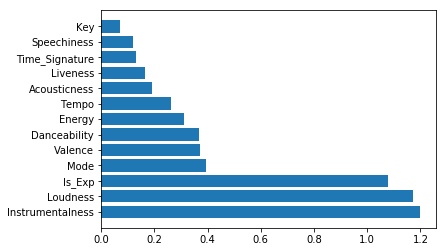

In [30]:
params  = {
    "C": 10.0 ** np.arange(-3, 3)
}
lin_svm = SVC(kernel="linear", probability=True)
clf = best_classifier(X_train,y_train,lin_svm,params)

print(clf)

joblib.dump(clf, "lin_svm.pkl")

y_pred = clf.predict(X_test)
training = clf.score(X_train, y_train)
testing  = clf.score(X_test,  y_test)
print("Training Accuracy: {}".format(training))
print("Testing  Accuracy: {}".format(testing))
print(confusion_matrix(y_test,y_pred,labels=genres))
print(classification_report(y_test, y_pred))


graph_features(abs(clf.coef_[0]), x_cols, filename="linsvmfeats.png")

In [31]:

params  = {
    "C": 10.0 ** np.arange(-3, 3),
    "gamma": float(X.shape[0]) ** np.arange(-3, 2),
    "probability": [True,False]
}
rbf_svm = SVC(kernel="rbf")
clf = best_classifier(X_train,y_train,rbf_svm,params)

print(clf)

joblib.dump(clf, "rbf_svm.pkl")

y_pred = clf.predict(X_test)
training = clf.score(X_train, y_train)
testing  = clf.score(X_test,  y_test)
print("Training Accuracy: {}".format(training))
print("Testing  Accuracy: {}".format(testing))
print(confusion_matrix(y_test,y_pred,labels=genres))
print(classification_report(y_test, y_pred)) 


Scoring for accuracy
Done fitting
Score: 0.6335; Parameters {'C': 0.001, 'gamma': 5.5621024596506654e-12, 'probability': True}
Score: 0.6335; Parameters {'C': 0.001, 'gamma': 5.5621024596506654e-12, 'probability': False}
Score: 0.6098; Parameters {'C': 0.001, 'gamma': 3.139250628226836e-08, 'probability': True}
Score: 0.6098; Parameters {'C': 0.001, 'gamma': 3.139250628226836e-08, 'probability': False}
Score: 0.6117; Parameters {'C': 0.001, 'gamma': 0.00017717930545712261, 'probability': True}
Score: 0.6117; Parameters {'C': 0.001, 'gamma': 0.00017717930545712261, 'probability': False}
Score: 0.3748; Parameters {'C': 0.001, 'gamma': 1.0, 'probability': True}
Score: 0.3748; Parameters {'C': 0.001, 'gamma': 1.0, 'probability': False}
Score: 0.1679; Parameters {'C': 0.001, 'gamma': 5644.0, 'probability': True}
Score: 0.1679; Parameters {'C': 0.001, 'gamma': 5644.0, 'probability': False}
Score: 0.6335; Parameters {'C': 0.01, 'gamma': 5.5621024596506654e-12, 'probability': True}
Score: 0.63